### import libraries

In [5]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

### set up credentials to connect to remote database

In [6]:
# use the credentials provided in the course

conn = {
    'host': 'da-class-db.cxcjjheb3bem.us-east-1.rds.amazonaws.com',
    'port': '3306',
    'database': 'supermarket',
    'username': 'brian_mukeswe',
    'password': open('password.txt','r').read()
    }

### Write query to fetch all the supermarket data

In [7]:
sqlQuery = '''
    select timestamp, t3.product, t3.location, quantity, t2.price, t1.category, t1.unit_cost_of_goods
    from transactions t3

    left join prices t2 on t3.product=t2.product and t3.location=t2.location
    left join products t1 on t3.product=t1.product

    order by 1
'''

### run query to fetch the data

In [8]:
# create connection string
connectionString = f'mysql+pymysql://{conn["username"]}:{conn["password"]}@{conn["host"]}/{conn["database"]}'

# create connection engine
engine = create_engine(connectionString) 

# fetch the data
supermarket = pd.read_sql(sql=sqlQuery, con=engine)

### take a peek at the returned data

In [9]:
supermarket.head()

,timestamp,product,location,quantity,price,category,unit_cost_of_goods
0,2021-03-01 07:00:00,loaves,location_2,10.0,3094.0,bakery,2000.0
1,2021-03-01 08:00:00,hand soap,location_2,25.0,3929.0,personal care,2300.0
2,2021-03-01 08:00:00,oranges,location_2,28.0,1474.0,fruits,800.0
3,2021-03-01 08:00:00,hand soap,location_2,16.0,3929.0,personal care,2300.0
4,2021-03-01 08:00:00,toilet paper,location_2,17.0,3164.0,toileteries,1700.0


#### Generate a daily report summarizing the transaction information for each location. The report must include the follwoing information:
- leading products
- lagging products
- busiest hours
- slowest hours
- cummulative month volumes

In [10]:
# add revenue and date columns
revenue = supermarket.price * supermarket.quantity
revenue.name = 'revenue'

date = supermarket.timestamp.apply(lambda d: str(d.__format__('%Y-%m-%d')))
date.name = 'date'
supermarket = pd.concat([supermarket, revenue, date], axis=1)
supermarket.head()

,timestamp,product,location,quantity,price,category,unit_cost_of_goods,revenue,date
0,2021-03-01 07:00:00,loaves,location_2,10.0,3094.0,bakery,2000.0,30940.0,2021-03-01
1,2021-03-01 08:00:00,hand soap,location_2,25.0,3929.0,personal care,2300.0,98225.0,2021-03-01
2,2021-03-01 08:00:00,oranges,location_2,28.0,1474.0,fruits,800.0,41272.0,2021-03-01
3,2021-03-01 08:00:00,hand soap,location_2,16.0,3929.0,personal care,2300.0,62864.0,2021-03-01
4,2021-03-01 08:00:00,toilet paper,location_2,17.0,3164.0,toileteries,1700.0,53788.0,2021-03-01


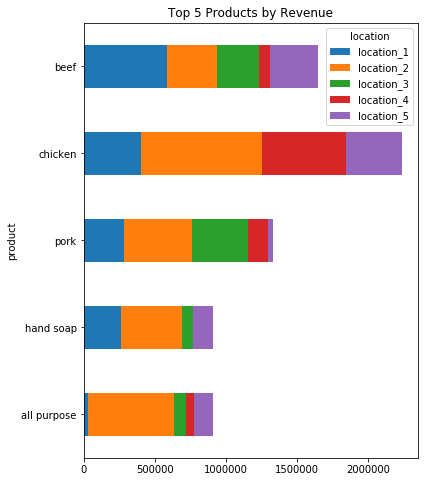

In [13]:
dateStr = '2021-03-12'
dateData = supermarket.query(f'date=="{dateStr}"')

# leading products
products = dateData.groupby(['product','location'])
products = products.revenue.sum().unstack(level=1)

top5 = dateData.groupby('product').revenue.sum().sort_values(ascending=True)[-5:]
top = filter(lambda i: any([i==p for p in top5.index]), products.index)


products.loc[list(top)].sort_values(by='location_1').plot(kind='barh',
                  figsize=(6,8),
                  title='Top 5 Products by Revenue',
                  stacked=True,
                  )
                  


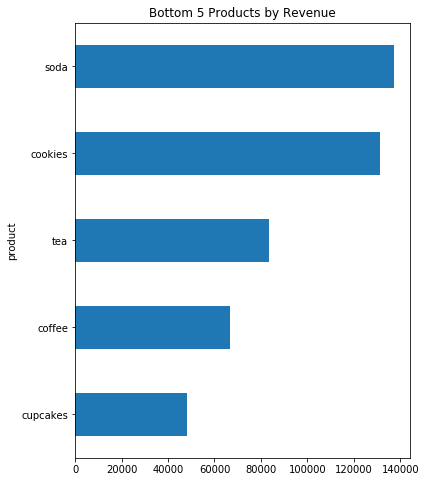

In [98]:
# lagging products
products = dateData.groupby('product').revenue.sum().sort_values(ascending=True)

products[:5].plot(kind='barh',
                  figsize=(6,8),
                  title='Bottom 5 Products by Revenue')

### Busiest hour and slowest hour

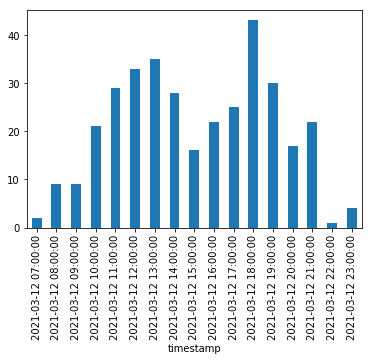

In [47]:
hours = dateData.groupby('timestamp').product.count()
hours.plot(kind='bar')

### Cummulative trend

In [14]:
dateStr = '2021-03-05'
toDate =  supermarket.query(f'date<="{dateStr}"')
toDate = toDate.groupby(['date','location']).sum().revenue.unstack(level=1)
toDate

location,location_1,location_2,location_3,location_4,location_5
date,,,,,
2021-03-01,2789076.0,5726332.0,2391271.0,2329652.0,2642341.0
2021-03-02,2114024.0,4818970.0,2926219.0,2172263.0,2817364.0
2021-03-03,2527344.0,4022612.0,1796802.0,2939719.0,3131008.0
2021-03-04,2885834.0,4098081.0,1646225.0,1861291.0,2073700.0
2021-03-05,2501974.0,3591962.0,2645653.0,2320182.0,2583739.0


In [107]:
toDateCum = toDate.cumsum()
toDateCum

location,location_1,location_2,location_3,location_4,location_5
date,,,,,
2021-03-01,2789076.0,5726332.0,2391271.0,2329652.0,2642341.0
2021-03-02,4903100.0,10545302.0,5317490.0,4501915.0,5459705.0
2021-03-03,7430444.0,14567914.0,7114292.0,7441634.0,8590713.0
2021-03-04,10316278.0,18665995.0,8760517.0,9302925.0,10664413.0
2021-03-05,12818252.0,22257957.0,11406170.0,11623107.0,13248152.0
2021-03-06,14571376.0,26562640.0,13337988.0,13575460.0,15931751.0
2021-03-07,17690985.0,30399014.0,15531296.0,16294545.0,18604887.0
2021-03-08,20027053.0,35352562.0,17755196.0,19457561.0,20772710.0
2021-03-09,23013849.0,38857264.0,19692402.0,22225386.0,22026044.0


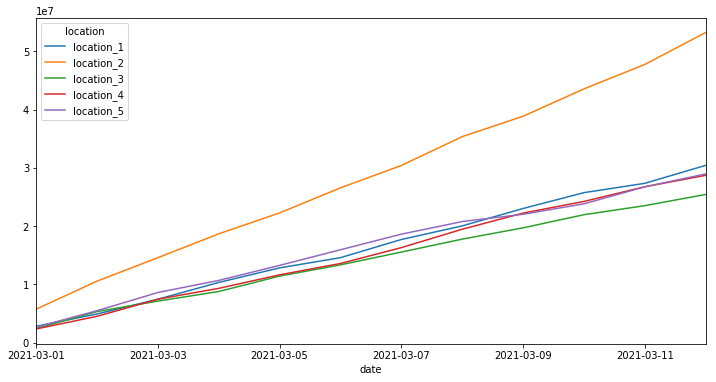

In [109]:
toDateCum.plot(kind='line', figsize=(12,6))

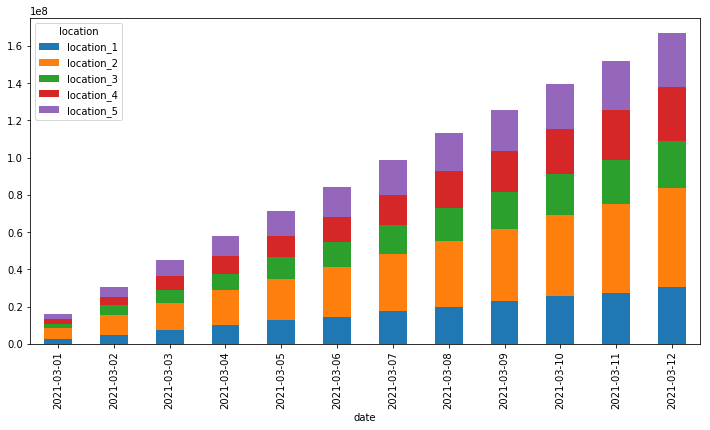

In [110]:
toDateCum.plot(kind='bar', figsize=(12,6), stacked=True)